<a href="https://colab.research.google.com/github/Git-Hub-Pro/Kalmanfilter/blob/master/pose_orientation_fusion_kf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy import io

자이로와 가속도계의 상호 보완적인 특성을 이용해, 가속도계로 자이로를 보상하는 센서 융합을 하려고 한다. 그런데 시스템 모델이 칼만 필터가 적용되지 않는 형태였다. 그래서 상태 변수를 오일러각에서 쿼터니언으로 바꾸고, 측정값도 오일러각에서 쿼터니언으로 바꿨다. 그랬더니 시스템 모델이 칼만 필터를 쓸 수 있는 형태가 되었다.

In [0]:
input_gyro_mat = io.loadmat('/content/gdrive/My Drive/data/kalmanfilter/source/11.ARS/ArsGyro.mat')
input_accel_mat = io.loadmat('/content/gdrive/My Drive/data/kalmanfilter/source/11.ARS/ArsAccel.mat')

In [0]:
def get_gyro(i):
    """Measure angular velocity using gyro."""
    p = input_gyro_mat['wx'][i][0]  # input_mat['wx']: (41500, 1)
    q = input_gyro_mat['wy'][i][0]  # input_mat['wy']: (41500, 1)
    r = input_gyro_mat['wz'][i][0]  # input_mat['wz']: (41500, 1)
    return p, q, r

In [0]:
def get_accel(i):
    """Measure angular acceleration using accelerometer (G-meter)."""
    ax = input_accel_mat['fx'][i][0]  # input_mat['fx']: (41500, 1)
    ay = input_accel_mat['fy'][i][0]  # input_mat['fy']: (41500, 1)
    az = input_accel_mat['fz'][i][0]  # input_mat['fz']: (41500, 1)
    return ax, ay, az

In [0]:
def accel2euler(ax, ay, az, phi, the, psi):
    """Calculate Euler angle (Pose Orientation)."""
    g = 9.8  # 9.8 [m/s^2]
    cosThe = np.cos(the)
    phi = np.arcsin(-ay / (g * cosThe))
    the = np.arcsin(ax / g)
    psi = psi
    return phi, the, psi

In [0]:
def euler2quaternion(phi, the, psi):
    """Euler angle to Quaternion for state variables."""
    sinPhi = np.sin(phi/2)
    cosPhi = np.cos(phi/2)
    sinThe = np.sin(the/2)
    cosThe = np.cos(the/2)
    sinPsi = np.sin(psi/2)
    cosPsi = np.cos(psi/2)

    q = np.array([cosPhi * cosThe * cosPsi + sinPhi * sinThe * sinPsi,
                  sinPhi * cosThe * cosPsi - cosPhi * sinThe * sinPsi,
                  cosPhi * sinThe * cosPsi + sinPhi * cosThe * sinPsi,
                  cosPhi * cosThe * sinPsi - sinPhi * sinThe * cosPsi])
    return q

In [0]:
def quaternion2euler(q):
    """Quaternion to Euler angle for drawing."""
    phi_esti = np.arctan2(2 * (q[2]*q[3] + q[0]*q[1]), 1 - 2 * (q[1]**2 + q[2]**2))
    the_esti = -np.arcsin(2 * (q[1]*q[3] - q[0]*q[2]))
    psi_esti = np.arctan2(2 * (q[1]*q[2] + q[0]*q[3]), 1 - 2 * (q[2]**2 + q[3]**2))
    return phi_esti, the_esti, psi_esti

In [0]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm."""
    # (1) Prediction.
    x_pred = A @ x_esti
    P_pred = A @ P @ A.T + Q

    # (2) Kalman Gain.
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

    # (3) Estimation.
    x_esti = x_pred + K @ (z_meas - H @ x_pred)

    # (4) Error Covariance.
    P = P_pred - K @ H @ P_pred

    return x_esti, P

In [0]:
# Input parameters.
n_samples = 41500
dt = 0.01

In [0]:
# Initialization for system model.
# Define matrix with rank 2 for matrix operation.
#dt = time_step
A = None
H = np.eye(4)
Q = 0.0001 * np.eye(4)
R = 10 * np.eye(4)

# Initialization for estimation.
x_0 = np.array([1, 0, 0, 0])  # (q0, q1, q2, q3) by my definition.
P_0 = np.eye(4)

In [0]:
time = np.arange(n_samples) * dt
phi_esti_save = np.zeros(n_samples)
the_esti_save = np.zeros(n_samples)
psi_esti_save = np.zeros(n_samples)

In [0]:
phi, the, psi = 0, 0, 0
x_esti, P = None, None
for i in range(n_samples):
    p, q, r = get_gyro(i)
    A = np.eye(4) + dt / 2 * np.array([[0, -p, -q, -r],
                                       [p,  0,  r, -q],
                                       [q, -r,  0,  p],
                                       [r,  q, -p,  0]])  
    ax, ay, az = get_accel(i)
    phi, the, psi = accel2euler(ax, ay, az, phi, the, psi)
    z_meas = euler2quaternion(phi, the, psi)

    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(z_meas, x_esti, P)

    phi_esti, the_esti, psi_esti = quaternion2euler(x_esti)

    phi_esti_save[i] = np.rad2deg(phi_esti)
    the_esti_save[i] = np.rad2deg(the_esti)
    psi_esti_save[i] = np.rad2deg(psi_esti)

Text(0, 0.5, 'Yaw ($\\psi$) angle [deg]')

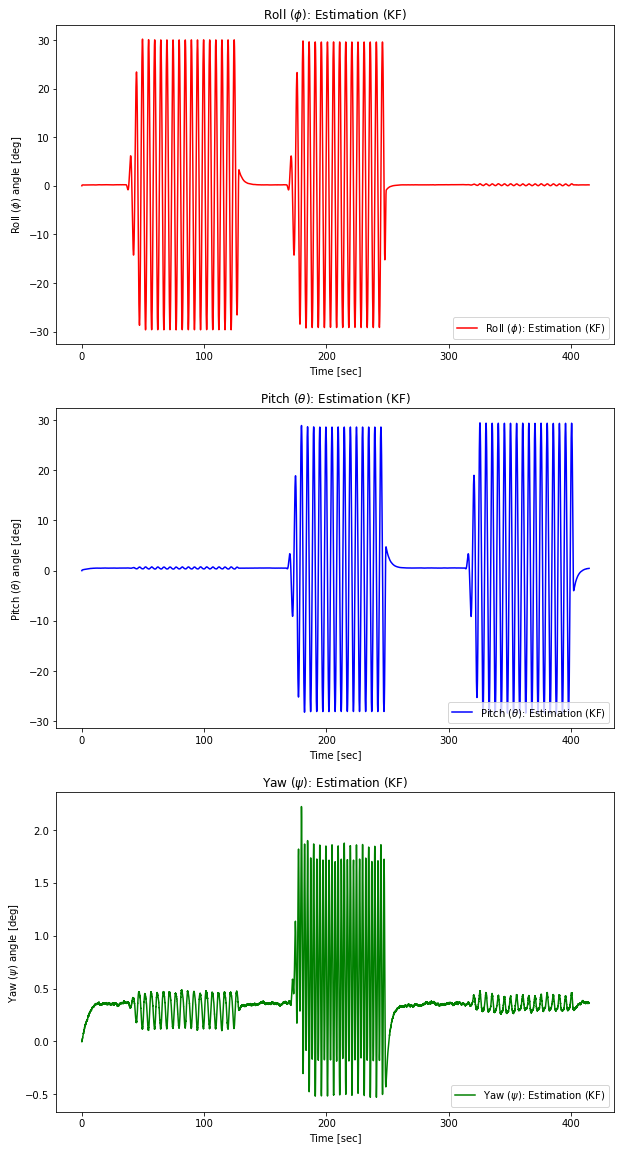

In [77]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

plt.subplot(3, 1, 1)
plt.plot(time, phi_esti_save, 'r', label='Roll ($\\phi$): Estimation (KF)', markersize=0.2)
plt.legend(loc='lower right')
plt.title('Roll ($\\phi$): Estimation (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Roll ($\phi$) angle [deg]')

plt.subplot(3, 1, 2)
plt.plot(time, the_esti_save, 'b', label='Pitch ($\\theta$): Estimation (KF)', markersize=0.2)
plt.legend(loc='lower right')
plt.title('Pitch ($\\theta$): Estimation (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Pitch ($\\theta$) angle [deg]')

plt.subplot(3, 1, 3)
plt.plot(time, psi_esti_save, 'g', label='Yaw ($\\psi$): Estimation (KF)', markersize=0.2)
plt.legend(loc='lower right')
plt.title('Yaw ($\\psi$): Estimation (KF)')
plt.xlabel('Time [sec]')
plt.ylabel('Yaw ($\\psi$) angle [deg]')